# Title: DM1590 Final Project Template

## Authors: Linus Bälter, Matei Cananau, Alexander Diez Gonzalez & David Tanudin

---

### Background and motivation

The problem we are addressing is to build a machine learning model that can predict the final grades of Portuguese students based on various factors such as demographics, social and economic background, school performance, and other related features.

The project felt relevant for us as students to help us better understand the factors that influence student performance. By building this machine learning model we can address these challenges and hopefully improve our and fellow students overall academic performance.


### Dataset

We are going to use a data set with attributes such as student grades, demographic, social and school related features to create a model to estimate a student’s academic performance. The data set can be found here, and is made up of data from 649 students at two Portuguese high schools. In total there are 33 attributes, including the three grades G1, G2 and G3.

### Methodology

We have created a machine learning model with supervised machine learning applications, this has been done with regression and classification. For regression we used the models Support Vector Machines (SVM) and Linear Regression with the algorithms SVR and Lasso respectively. The regression models goal was to estimate the final grade of a student and has been evaluated with MSE and MAE as well as r2 score for accuracy of the prediction. 


The target for our classification model was to predict whether a student is in the top 90th percentile of the class, this was done with Naive Bayes. Accuracy with f1 score has also been used to evaluate this supervised machine learning application. 

Unsupervised machine learning NMF has helped visualize if there are any underlying patterns, Kmeans clustering and PCA has also helped achieve the same tasks. 

In addition to these models we used feature selection and dimensionality reduction to encapsulate selected features that would improve our models. We used SelectKBest with chi2 for feature selection and NMF for an unsupervised dimensionality reduction. Upon pre-processing the data we performed supervised regression models on them, evaluating the results and comparing them to the previous results.  


---

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.metrics import f1_score

df = pd.read_csv('student-por.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


# Visualize the final grade [G3] distribution

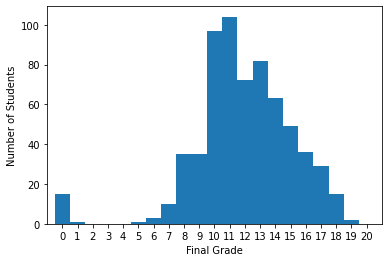

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
10%        8.800000
50%       12.000000
90%       16.000000
max       19.000000
Name: G3, dtype: float64

In [ ]:
bins = np.arange(21) - 0.5
plt.hist(df['G3'], bins)
plt.xticks(range(21))
plt.xlim([-1, 21])
plt.xlabel('Final Grade')
plt.ylabel('Number of Students')
plt.show()

df["G3"].describe(percentiles=[0.10, 0.5, 0.9])

# **Supervised Learning**
### Models using supervised learning

# Model 1: Naive Bayes Classifier
Redefine target column G3 as one of two classes: <br>
0: Score under the 90th-percentile of G3, <br>
1: Score equal or above the 90th-percentile of G3

In [ ]:
# We don't care about system warnings
import warnings
warnings.filterwarnings('ignore')

df_clean = df.copy()

print("G3 values BEFORE redefinition")
print(df_clean["G3"][0])
print(df_clean["G3"][645])

for i in range(648+1):
    if df_clean["G3"][i] < 16:  # If grade score is below 16, let this student's grade be represented as class 0.
        df_clean["G3"][i] = 0
    else:
        df_clean["G3"][i] = 1

print("G3 values AFTER redefinition")
print(df_clean["G3"][0])
print(df_clean["G3"][645])


G3 values BEFORE redefinition
11
16
G3 values AFTER redefinition
0
1


### Prepare and encode the data
Split up the data's respective categorical and numerical columns

In [ ]:
categorical_columns = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]

# With G1 and G2
all_training_data = df_clean
numerical_columns = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences", "G1", "G2"]

# Without G1 and G2 [very low accuracy // Skitsnack]
# all_training_data = df_clean.drop(["G2", "G1"], axis=1)
# numerical_columns = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences"]

# Encode the categorical columns
training_data_encoded = pd.DataFrame()
for col in categorical_columns:
  LE = LabelEncoder()
  dt = LE.fit_transform(all_training_data[col])
  training_data_encoded[col] = dt

# Combine with the numerical columns
for col in numerical_columns:
  training_data_encoded[col] = all_training_data[col]

# Add in the encoded target column (G3)
LE = LabelEncoder()
training_data_encoded['G3'] = LE.fit_transform(all_training_data['G3'])

### Train the model
Use CategoricalNB() and GaussianNB() to create a model then test it

In [ ]:
def split_train_pred():
    trainingSet, testSet = train_test_split(training_data_encoded, test_size=0.3)

    cnb = CategoricalNB(fit_prior=False)
    gnb = GaussianNB()

    cnb.fit(trainingSet.filter(categorical_columns, axis=1), trainingSet['G3'])
    logP_categorical = cnb.predict_log_proba(testSet.filter(categorical_columns, axis=1))

    gnb.fit(trainingSet.filter(numerical_columns, axis=1), trainingSet['G3'])
    logP_numerical = gnb.predict_log_proba(testSet.filter(numerical_columns, axis=1))
    
    # estimate prior
    probclass0 = np.sum(trainingSet['G3']==0)/len(trainingSet['G3'])

    logP = logP_categorical + logP_numerical + np.log([probclass0,1-probclass0])
    
    predictions = np.argmax(logP,axis=1)

    accuracy = sum(predictions==testSet['G3'])/testSet.shape[0]
    f1 = f1_score(testSet["G3"], predictions)

    return accuracy, f1

accuracies = []
sum_accuracies = 0

f1_scores = []
sum_f1 = 0

iterations = 1000
for i in range(iterations):
    acc, f1 = split_train_pred()
    accuracies.append(acc)
    sum_accuracies += acc

    f1_scores.append(f1)
    sum_f1 += f1

avg_accuracy = sum_accuracies/iterations
med_accuracy = accuracies[int(len(accuracies)/2)]
min_accuracy = min(accuracies)
max_accuracy = max(accuracies)
print(f"Average accuracy after {iterations} runs: {avg_accuracy}")
print(f"Median accuracy after {iterations} runs: {med_accuracy}")
print(f"Min accuracy after {iterations} runs: {min_accuracy}")
print(f"Max accuracy after {iterations} runs: {max_accuracy}")

avg_f1 = sum_f1/iterations
med_f1 = f1_scores[int(len(f1_scores)/2)]
min_f1 = min(f1_scores)
max_f1 = max(f1_scores)
print(f"Average F1-score after {iterations} runs: {avg_f1}")
print(f"Median F1-score after {iterations} runs: {med_f1}")
print(f"Min F1-score after {iterations} runs: {min_f1}")
print(f"Max F1-score after {iterations} runs: {max_f1}")

Average accuracy after 1000 runs: 0.879025641025637
Median accuracy after 1000 runs: 0.9384615384615385
Min accuracy after 1000 runs: 0.6512820512820513
Max accuracy after 1000 runs: 0.9794871794871794
Average F1-score after 1000 runs: 0.6805748052341225
Median F1-score after 1000 runs: 0.793103448275862
Min F1-score after 1000 runs: 0.26829268292682923
Max F1-score after 1000 runs: 0.9090909090909091


# Model 2: SVR [SVM Regression]
Clean the data by mapping the categorical values to numerical in order for the computer to read and compare them

In [ ]:
df_clean = df.copy()

# With G1 and G2
df_clean = df.copy()

# Without G1 and G2 [very low accuracy // Skitsnack]
# df_clean = df.copy().drop(["G2", "G1"], axis=1)


binary = {'GP': 1, 'MS': 0}
df_clean['school'] = df_clean['school'].map(binary)

binary = {'yes': 1, 'no': 0}
df_clean['schoolsup'] = df_clean['schoolsup'].map(binary)
df_clean['famsup'] = df_clean['famsup'].map(binary)
df_clean['paid'] = df_clean['paid'].map(binary)
df_clean['activities'] = df_clean['activities'].map(binary)
df_clean['nursery'] = df_clean['nursery'].map(binary)
df_clean['higher'] = df_clean['higher'].map(binary)
df_clean['internet'] = df_clean['internet'].map(binary)
df_clean['romantic'] = df_clean['romantic'].map(binary)

binary = {'M': 1, 'F': 0}
df_clean['sex'] = df_clean['sex'].map(binary)

binary = {'home': 0, 'reputation': 1, 'course': 2, 'other': 3}
df_clean['reason'] = df_clean['reason'].map(binary)

binary = {'U': 1, 'R': 0}
df_clean['address'] = df_clean['address'].map(binary)

binary = {'T': 1, 'A': 0}
df_clean['Pstatus'] = df_clean['Pstatus'].map(binary)


binary = {'LE3': 1, 'GT3': 0}
df_clean['famsize'] = df_clean['famsize'].map(binary)

binary = {'mother': 0, 'father': 1, 'other': 2}
df_clean['guardian'] = df_clean['guardian'].map(binary)

binary = {'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4}
df_clean['Mjob'] = df_clean['Mjob'].map(binary)
df_clean['Fjob'] = df_clean['Fjob'].map(binary)

### Train the model
Use SVR imported from SVM to create a model then test it

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import metrics

X = df_clean.drop(['G3'], axis=1)
y = df_clean['G3']

# Check if there are any null values
df_clean.isnull().any()	# OK

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor = SVR(kernel='linear')
regressor.fit(X_train, y_train)

# Predict the test set results
y_pred = regressor.predict(X_test)

print(regressor.score(X_test, y_test))

# Print the mean absolute error (MAE)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

# Print the mean squared error (MSE)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

0.8569196175720488
Mean Absolute Error: 0.702255016952855
Mean Squared Error: 1.01260272543862


# Model 3: Lasso
Use Lasso from the sklearn library; train and test the model

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Predict the test set results
y_pred_lasso = lasso.predict(X_test)

# Print the accuracy
accuracy_lasso = lasso.score(X_test, y_test)
print("---Lasso---")
print(f"Accuracy: {100*accuracy_lasso:.2f}%")

# Print the mean absolute error (MAE)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print(f"Mean absolute error: {mae_lasso:.6f}")

# Print the mean squared error (MSE)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Mean squared error: {mse_lasso:.6f}\n")

---Lasso---
Accuracy: 85.35%
Mean absolute error: 0.736552
Mean squared error: 1.036758



# **Unsupervised Learning**
### Models using feature selection and unsupervised dimensionality reduction

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Seperate target and test
X = df_clean.iloc[:, :-1].values
y = df_clean['G3'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Feature selection with SelectKBest, remove the remaining features
selector = SelectKBest(chi2, k=5)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

# Print the selected features
selected_features = selector.get_support(indices=True)
feature_names = df.columns[:-1][selected_features]
print('Selected features:', feature_names)

# Predict with Lasso on the selected features
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train_new, y_train)
y_pred = lasso.predict(X_test_new)

# Print Results
print("Accuracy:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

Selected features: Index(['failures', 'Dalc', 'absences', 'G1', 'G2'], dtype='object')
Accuracy: 0.8343937482543045
MSE: 2.243360427987055
MAE: 0.8837906214204521


# Visualize and train the data
Scatter the plot to visualize the data and train a model using the featurees with Lasso

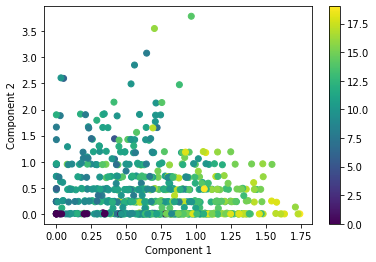

Accuracy: 0.8146010077182514
MSE: 2.2917021945624354
MAE: 0.9808145791693215


In [ ]:
from sklearn.decomposition import NMF

# Perform NMF dimensionality reduction
nmf = NMF(n_components=5, init='random')
X_nmf = nmf.fit_transform(X)

# Plot the reduced dataset
plt.scatter(X_nmf[:, 0], X_nmf[:, 1], c=y, cmap='viridis')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar()
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_nmf, y, test_size=0.3)

# Predict with Lasso on the reduced dataset
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# Print Results
print("Accuracy:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# KMeans & PCA
Train and test the data using SGD, visualize the PCA, calculate KMeans and predict. Also test the cross validation score using GridSearchCV

Score: 0.8571844669114509
Scores: [1.28584678 0.77782262 1.13732309 1.67492084 1.7791238  1.30667215
 1.55572349 0.96410119 0.94537762 1.4694467 ]
Mean: 1.28963582839163
Standard deviation: 0.3164049067878988


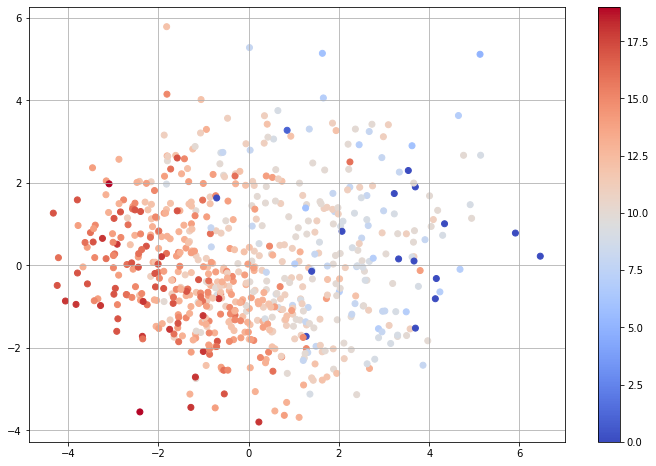

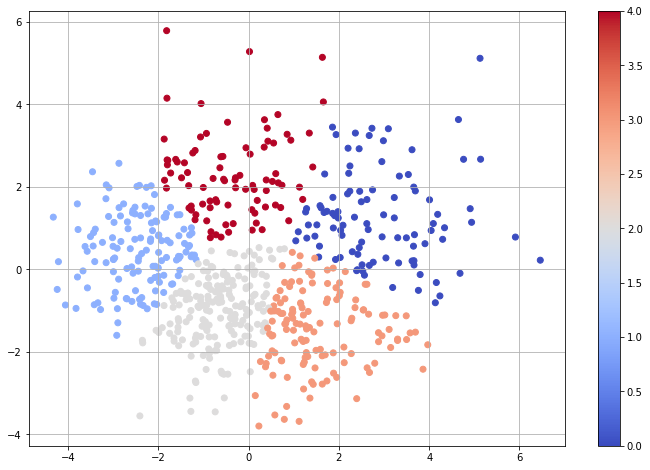

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X_train, y_train)

print('Score:', sgd_reg.score(X_test, y_test))

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='coolwarm')
plt.grid()
plt.colorbar()


kmeans = KMeans(n_clusters=5)
kmeans.fit(X_reduced)
y_kmeans = kmeans.predict(X_reduced)

plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_kmeans, cmap='coolwarm')
plt.grid()
plt.colorbar()


param_grid = [
    {'penalty': ['l1', 'l2'], 'alpha': [
        0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
]

# sgd_reg = SGDRegressor()

grid_search = GridSearchCV(sgd_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

grid_search.best_params_

grid_search.best_estimator_


y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


scores = cross_val_score(grid_search.best_estimator_, X_train,
                         y_train, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)


def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(rmse_scores)


---
## Discussion

In supervised machine learning, our SVR regression model had an accuracy score of 86%, a mean absolute error of 0.74 units and a mean squared error of 1.4 units. Our LASSO model had an accuracy score of 88%, a mean absolute error of 0.70 units and a mean squared error of 1.2 units. Our Naive Bayes classifier after making 1000 runs had an accuracy of 88% for the top 90th percentile of students. It also had an F1-score accuracy of 69%.

In unsupervised machine learning our KMeans clustering where we let k equal to 5. Then we tested the cross validation scores using GridsearchCV and the model had an accuracy of about 86% with a standard deviation of about 0.32 units. Our NMF decomposition model had an accuracy of 86% with a mean absolute error or 0.76 units and a mean squared error of 1.3 units. A regression model based on the features selected by SelectKbest, chi2 had an accuracy of 84% with a mean absolute error or 0.78 units and a mean square error of 1.7 units.

Then we ran all these models again but this time we excluded the grades G1 and G2 from the training dataset and we got a significantly lower accuracy, on average, of about 24% and a mean square error, on average, of about 7.09 units.

Our regression model and classifier were able to achieve accuracy scores in the mid 80’s but only when including the features G1 and G2. In the case of the classifier, this is still around 7 % pts worse than guessing blindly. Without G1 and G2 the classifier’s average accuracy drops by 18 % pts and the F1-score is more than halved, from 0.68 down to 0.25. The regression model’s accuracy drops even more, from 86% to 24%.

One issue we had with the calculation of the models’ accuracies was that depending on the training and test split, the models sometimes could get a lot lower scores than the median value. With the classifier for example, the accuracy could be 92% on one run, but every now and then it would dip down below 50% and then go back up the next time we ran the code. Giving the function a set random-state removed these dips, and therefore our best guess is that these dips occur when the training and or test set contain an unrepresentative selection of the data that then doesn’t match the opposite set. This could most likely be solved by simply having a larger data set, since the one we used had less than 700 students worth of data.

Even though the results indicate that it is possible to very roughly estimate a student’s grades given this set of demographic and personal factors, we also have to be open to the possibility that there could be better factors to use for this purpose. While many of them can be expected to apply across education systems, such as time spent studying and the student’s desire to pursue higher education, it might be unsuitable to try and project the correlations within this data set onto students in other countries.

Finally there is always the human element. While we want to believe that we know what we are doing and have done it well, there is definitely a non-zero chance that there are errors in the code and that there are aspects that we have missed due our limited knowledge.


## Acknowledgments

Our group tried to work in parallel by having everyone work on their own model. This naturally led to some confusion and made it a bit difficult to bring it all together in the end. We were however then able to compare methods and results to see if we could draw similar conclusions, which was nice. For example, Linus tried making a classifier reusing code from lab 5, a linear regression model and a polynomial regression model (the latter two not making the final cut however). The results from these could then be compared to those of Matei’s, Alexander’s and David’s models. Therefore we are unable to say that one specific person stood for one specific thing.

## Final memes

https://docs.google.com/presentation/d/17YKQasU3dr5cNW06eoI5QCmL_I3P2wUk5LqayknIo4g/edit?usp=sharing